<a href="https://colab.research.google.com/github/Huyrua27/Exercise/blob/main/Pytorch01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Thư viện
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import os

# Cài đặt thiết bị để code có thể chạy trên cả CPU và GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")


Sử dụng thiết bị: cpu


In [12]:
#1. Tạo dataset đường thẳng
def create_dataset_linear(w = 0.3, bias = 0.9, num_samples=100, train_split=0.8, seed=42):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

  #Tạo input
  X = torch.linspace(0, 1, num_samples).reshape(-1, 1)

  #Tạo nhãn Y với nhiễu
  y = w*X + bias + 0.1*torch.randn_like(X)

  #Chia data thành settrain và settest
  train_size = int(num_samples*train_split)
  X_train, X_test = X[:train_size], X[train_size:]
  y_train, y_test = y[:train_size], y[train_size:]

  #Chuyển data đến device
  X_train, X_test = X_train.to(device), X_test.to(device)
  y_train, y_test = y_train.to(device), y_test.to(device)

  return X_train, y_train, X_test, y_test

def plot_data(X_train, y_train, X_test, y_test, predictions=None, title="Data linear"):
  # Chuyển dữ liệu về CPU để vẽ bằng matplotlib
    X_train_cpu = X_train.cpu().numpy()
    y_train_cpu = y_train.cpu().numpy()
    X_test_cpu = X_test.cpu().numpy()
    y_test_cpu = y_test.cpu().numpy()

    plt.figure(figsize=(10,6))
    plt.scatter(X_train_cpu, y_train_cpu, color='blue', label="Data train")
    plt.scatter(X_test_cpu, y_test_cpu, color='red', label="Data test")

    if predictions is not None:
        predictions_cpu = predictions.cpu().numpy()
        plt.scatter(X_test_cpu, predictions_cpu, color='green', label='Predictions')

    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()


In [18]:
#2. Tạo mô hình pytorch bằng kế thừa nn.Module
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(in_features=1, out_features=1)

  def forward(self, x):
    return self.linear(x)

#test
model = LinearModel()
x = torch.tensor([[1.0]])
y_pred = model(x)
print(y_pred)

tensor([[-0.2394]], grad_fn=<AddmmBackward0>)


In [19]:
# 3. Tạo hàm mất mát, bộ tối ưu và huấn luyện mô hình
def train_model(model, X_train, y_train, X_test, y_test, epochs=300, lr=0.01, test_interval=20):
    # Chuyển mô hình đến thiết bị
    model.to(device)

    # Tạo hàm mất mát và bộ tối ưu
    loss_fn = nn.L1Loss()  # Sử dụng hàm mất mát L1
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # Tối ưu hóa bằng SGD với learning rate = 0.01

    # Vòng lặp huấn luyện
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Đặt mô hình ở chế độ huấn luyện
        model.train()

        # Truyền tín hiệu tiến (forward pass)
        y_pred = model(X_train)

        # Tính toán mất mát
        loss = loss_fn(y_pred, y_train)
        train_losses.append(loss.item())

        # Truyền tín hiệu ngược (backward pass)
        optimizer.zero_grad()  # Xóa gradient
        loss.backward()  # Tính toán gradient
        optimizer.step()  # Cập nhật tham số

        # Kiểm tra sau mỗi 'test_interval' epoch
        if epoch % test_interval == 0:
            # Đặt mô hình ở chế độ đánh giá
            model.eval()

            with torch.no_grad():  # Không tính gradient khi đánh giá
                test_pred = model(X_test)
                test_loss = loss_fn(test_pred, y_test)
                test_losses.append(test_loss.item())

                print(f"Epoch: {epoch}, Mất mát huấn luyện: {loss.item():.4f}, Mất mát kiểm tra: {test_loss.item():.4f}")

    return train_losses, test_losses

In [20]:
# 4. Thực hiện dự đoán với mô hình đã huấn luyện
def make_predictions(model, X_test):
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    with torch.no_grad():  # Không tính gradient khi dự đoán
        predictions = model(X_test)
    return predictions

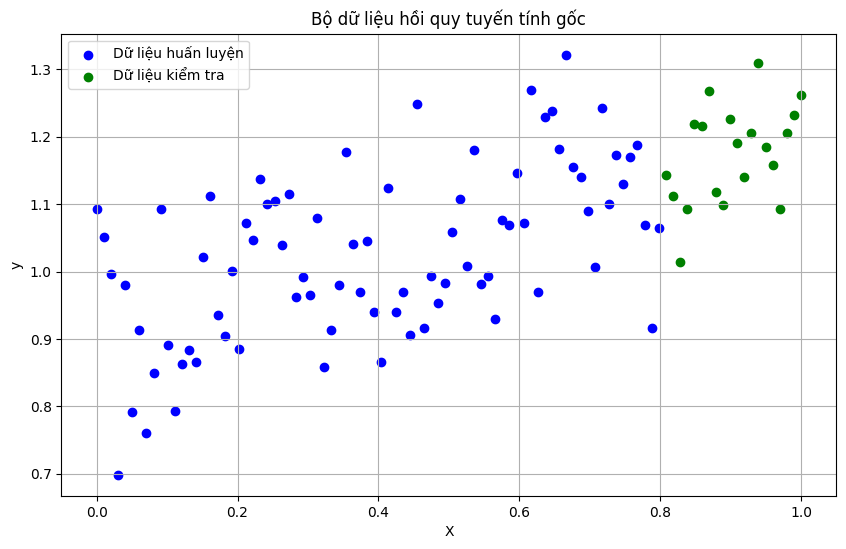

Cấu trúc mô hình: LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
State dict ban đầu: OrderedDict([('linear.weight', tensor([[0.1564]])), ('linear.bias', tensor([-0.8799]))])
Epoch: 0, Mất mát huấn luyện: 1.8439, Mất mát kiểm tra: 1.8994
Epoch: 20, Mất mát huấn luyện: 1.6120, Mất mát kiểm tra: 1.6273
Epoch: 40, Mất mát huấn luyện: 1.3802, Mất mát kiểm tra: 1.3551
Epoch: 60, Mất mát huấn luyện: 1.1484, Mất mát kiểm tra: 1.0830
Epoch: 80, Mất mát huấn luyện: 0.9165, Mất mát kiểm tra: 0.8108
Epoch: 100, Mất mát huấn luyện: 0.6847, Mất mát kiểm tra: 0.5387
Epoch: 120, Mất mát huấn luyện: 0.4529, Mất mát kiểm tra: 0.2666
Epoch: 140, Mất mát huấn luyện: 0.2305, Mất mát kiểm tra: 0.0523
Epoch: 160, Mất mát huấn luyện: 0.1336, Mất mát kiểm tra: 0.1502
Epoch: 180, Mất mát huấn luyện: 0.1227, Mất mát kiểm tra: 0.1846
Epoch: 200, Mất mát huấn luyện: 0.1180, Mất mát kiểm tra: 0.1919
Epoch: 220, Mất mát huấn luyện: 0.1150, Mất mát kiểm tra: 0.1869
Epoch: 240, Mất mát huấ

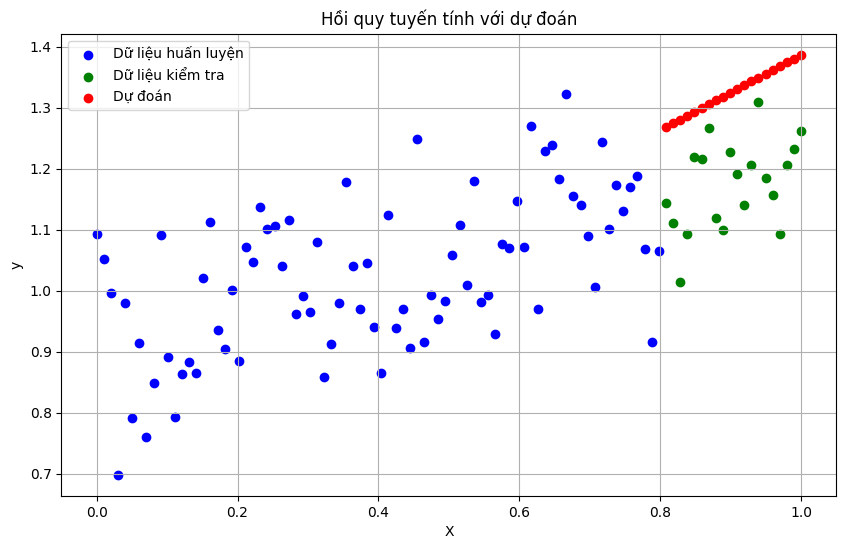

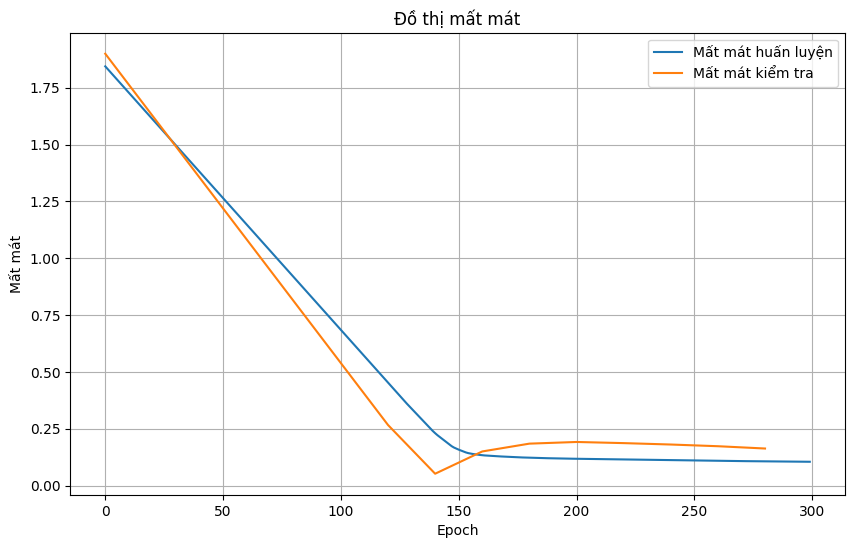

State dict cuối cùng của mô hình: OrderedDict([('linear.weight', tensor([[0.6184]])), ('linear.bias', tensor([0.7683]))])
Mô hình đã được lưu tại model.pth
Dự đoán có khớp không? True

Dự đoán của mô hình gốc (5 đầu tiên):
tensor([[1.2681],
        [1.2743],
        [1.2806],
        [1.2868],
        [1.2931]])

Dự đoán của mô hình đã tải (5 đầu tiên):
tensor([[1.2681],
        [1.2743],
        [1.2806],
        [1.2868],
        [1.2931]])


In [26]:
# 5. Lưu và tải mô hình
def save_and_load_model(model, save_path="model.pth"):
    # Lưu state dict của mô hình
    torch.save(model.state_dict(), save_path)
    print(f"Mô hình đã được lưu tại {save_path}")

    # Tạo một thể hiện mới của mô hình và tải state dict
    loaded_model = LinearModel()
    loaded_model.to(device)
    loaded_model.load_state_dict(torch.load(save_path, weights_only=True))
    loaded_model.eval()

    return loaded_model

# Thực thi chính
if __name__ == "__main__":
    # 1. Tạo bộ dữ liệu
    X_train, y_train, X_test, y_test = create_dataset_linear(w=0.3, bias=0.9, num_samples=100)

    # Vẽ dữ liệu gốc
    plot_data(X_train, y_train, X_test, y_test, title="Bộ dữ liệu hồi quy tuyến tính gốc")

    # 2. Tạo mô hình
    model = LinearModel()
    print("Cấu trúc mô hình:", model)
    print("State dict ban đầu:", model.state_dict())

    # 3. Huấn luyện mô hình
    train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test, epochs=300, lr=0.01, test_interval=20)

    # 4. Thực hiện dự đoán
    predictions = make_predictions(model, X_test)
    plot_data(X_train, y_train, X_test, y_test, predictions, title="Hồi quy tuyến tính với dự đoán")

    # Vẽ đồ thị mất mát
    plt.figure(figsize=(10, 6))
    plt.plot(range(0, 300), train_losses, label='Mất mát huấn luyện')
    plt.plot(range(0, 300, 20), test_losses, label='Mất mát kiểm tra')
    plt.title('Đồ thị mất mát')
    plt.xlabel('Epoch')
    plt.ylabel('Mất mát')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("State dict cuối cùng của mô hình:", model.state_dict())

    # 5. Lưu và tải mô hình
    loaded_model = save_and_load_model(model)
    loaded_predictions = make_predictions(loaded_model, X_test)

    # Kiểm tra xem dự đoán có khớp không
    is_match = torch.allclose(predictions, loaded_predictions)
    print(f"Dự đoán có khớp không? {is_match}")

    # So sánh một vài dự đoán
    print("\nDự đoán của mô hình gốc (5 đầu tiên):")
    print(predictions[:5])
    print("\nDự đoán của mô hình đã tải (5 đầu tiên):")
    print(loaded_predictions[:5])